In [1]:
! pip install --quiet -r ../requirements.txt 

In [2]:
import numpy as np
import torch
import copy
import math
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

import sys
import os
sys.path.append(os.path.expanduser("~/repos/NeurOps/pytorch"))
from neurops import *

from growprune import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/kaitlin/repos/NeurOps/pytorch/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kaitlin/repos/NeurOps/pytorch/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
hidden = [32]
regression = False

base_data = ToyData(64, 32, 5000, regression=regression, masked=True)
train_loader, val_loader, test_loader = split_dataset(base_data, val_size = 0.1, test_size = 0.1, batch_size = 128)

model = ModSequential(
        ModLinear(64, hidden[0], masked=True, prebatchnorm=True, learnable_mask=True),
        #ModLinear(hidden[0], hidden[1], masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(hidden[0], 1 if regression else 2, masked=True, prebatchnorm=True),
        track_activations=10,
        track_auxiliary_gradients=True
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() if regression else torch.nn.CrossEntropyLoss()

print("This model has {} effective parameters.".format(model.parameter_count(masked = True)))
#print("The conversion factor of this model is {} after layer {}.".format(model.conversion_factor, model.conversion_layer))

This model has 2178 effective parameters.


In [4]:
pre_losses, pre_accs, pre_acts = train(model, train_loader, optimizer, criterion, epochs=50, val_loader=val_loader, device=device, regression=regression, verbose=False, val_verbose=False, val_acts=True)
pre_vars = torch.cat([activation_variance(acts).unsqueeze(0) for acts in pre_acts["0"]], dim=0)
pre_svd_scores = torch.cat([svd_score(acts, difference=True).unsqueeze(0) for acts in pre_acts["0"]], dim=0)
pre_orthog_gap = [orthogonality_gap(acts) for acts in pre_acts["0"]]

Training 32 epochs per shift, shifting window by 32 indices 2 times
tensor(0.0009)
tensor(-0.0029)


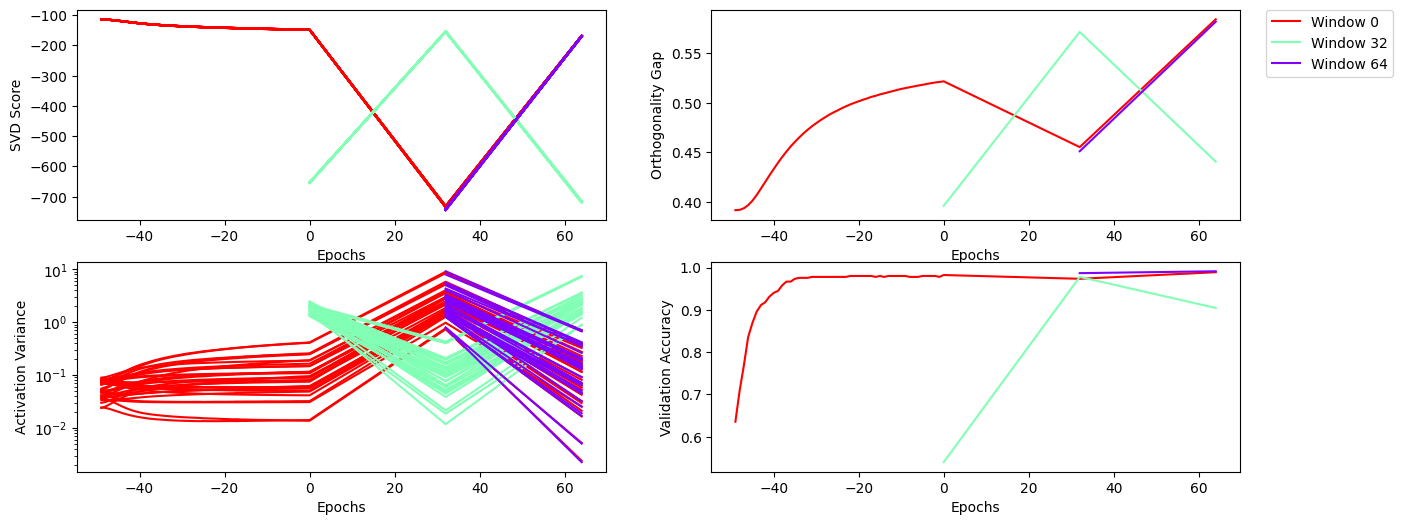

Training 16 epochs per shift, shifting window by 16 indices 4 times
tensor(-0.0010)
tensor(0.0009)
tensor(-0.0010)
tensor(-0.0029)


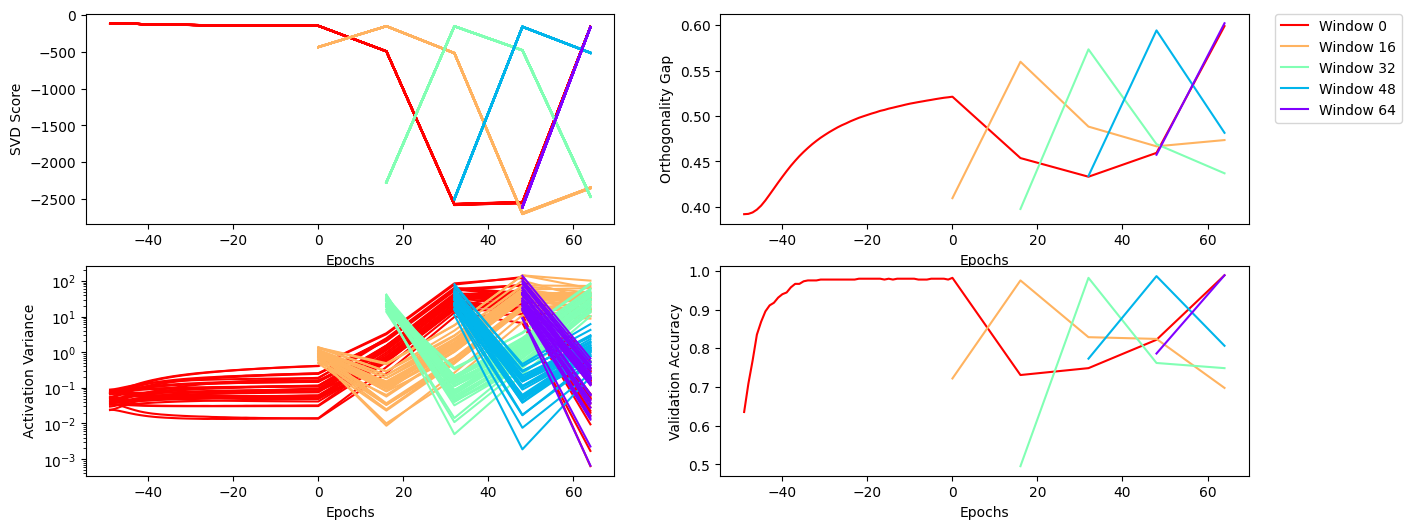

Training 8 epochs per shift, shifting window by 8 indices 8 times
tensor(-0.0027)
tensor(-0.0010)
tensor(-0.0001)
tensor(0.0009)
tensor(0.0007)
tensor(-0.0010)
tensor(-0.0019)
tensor(-0.0029)


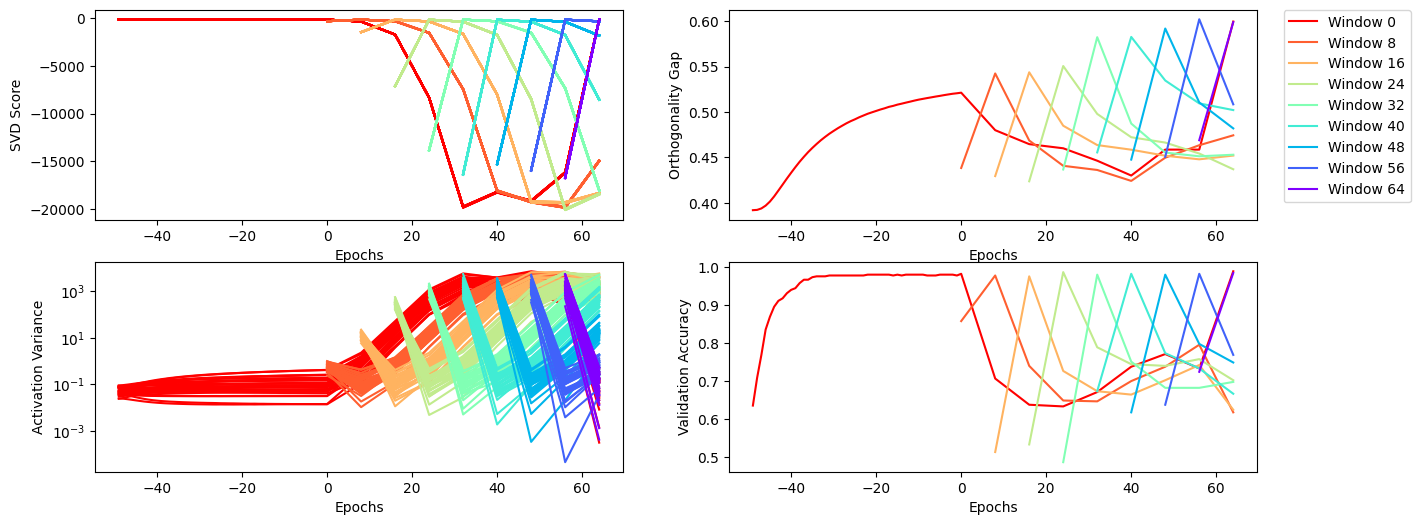

Training 4 epochs per shift, shifting window by 4 indices 16 times
tensor(-0.0038)
tensor(-0.0027)
tensor(-0.0022)
tensor(-0.0010)
tensor(0.0005)
tensor(-0.0001)
tensor(0.0006)
tensor(0.0009)
tensor(0.0018)
tensor(0.0007)
tensor(0.0002)
tensor(-0.0010)
tensor(-0.0025)
tensor(-0.0019)
tensor(-0.0026)
tensor(-0.0029)


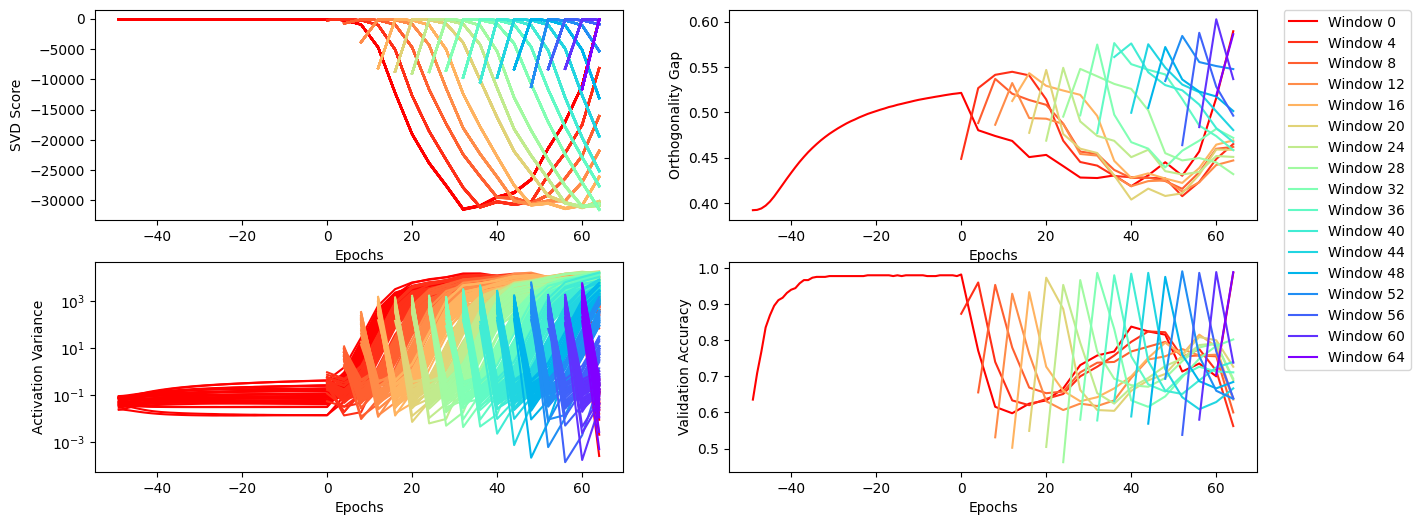

In [5]:
cmap = plt.get_cmap('rainbow')

#strat = "Mult"
#strat = "Add"
strat = "Window"

for power in range(int(math.log(base_data.input_dim, 2))-2):
    mod = copy.deepcopy(model)
    mod_optimizer = torch.optim.SGD(mod.parameters(), lr=0.01)
    mod_optimizer.load_state_dict(optimizer.state_dict())

    loss, acc = test(mod, val_loader, criterion, device=device, regression=regression, verbose=False)
    accs = [list(pre_accs)]
    #svd_scores = [svd_score(mod.activations["0"]).unsqueeze(0)]
    svd_scores = [pre_svd_scores]
    vars = [pre_vars]
    #orthog_gaps = [[orthogonality_gap(mod.activations["0"])]]
    orthog_gaps = [list(pre_orthog_gap)]

    timestamp = list(range(-50, 1))

    shift = 2**(int(math.log(base_data.input_dim, 2))-power-1)
    datasets = [val_loader]
    
    print("Training {} epochs per shift, shifting window by {} indices {} times".format(64//int(base_data.input_dim/shift), shift, int(base_data.input_dim/shift)))
    for step in range(int(base_data.input_dim/shift)):
        modded_data = copy.deepcopy(base_data)
        if strat == "Mult":
            modded_data.shift_distribution(multiplier=(-1)**step, recompute_y=False)
        elif strat == "Add":
            modded_data.shift_distribution(adder=((step+1)*shift)/32, recompute_y=False)
        elif strat == "Window":
            modded_data.shift_window((step+1)*shift)
        print(modded_data.X.mean())
        modded_train_loader, modded_val_loader, modded_test_loader = split_dataset(modded_data, val_size = 0.1, test_size = 0.1, batch_size = 128)
        datasets.append(modded_val_loader)
        loss, acc = test(mod, modded_val_loader, criterion, device=device, regression=regression, verbose=False)
        accs.append([acc])
        svd_scores.append(svd_score(mod.activations["0"], difference=True).unsqueeze(0))
        vars.append(activation_variance(mod.activations["0"]).unsqueeze(0))
        orthog_gaps.append([orthogonality_gap(mod.activations["0"])])
        loss_, acc_, acts_ = train(mod, modded_train_loader, mod_optimizer, criterion, epochs=64//int(base_data.input_dim/shift), val_loader=modded_val_loader, device=device, regression=regression, verbose=False, val_verbose=False, val_acts=True)
        timestamp.append(timestamp[-1]+64//int(base_data.input_dim/shift))
        for i, vl in enumerate(datasets):
            loss, acc = test(mod, vl, criterion, device=device, regression=regression, verbose=False)
            accs[i].append(acc)
            svd_scores[i] = torch.cat((svd_scores[i], svd_score(mod.activations["0"], difference=True).unsqueeze(0)), dim=0)
            vars[i] = torch.cat((vars[i], activation_variance(mod.activations["0"]).unsqueeze(0)), dim=0)
            orthog_gaps[i].append(orthogonality_gap(mod.activations["0"]))

    colors = [cmap(i) for i in np.linspace(1, 0, len(svd_scores))]
    fig, axs = plt.subplots(2,2, figsize=(15,6))
    for i, scores in enumerate(svd_scores):
        for neuron in range(scores.shape[1]):
            axs[0,0].plot(timestamp[-len(scores[:,neuron]):], scores[:,neuron], color=colors[i], label="{} {}".format(strat, int(i*(64//(len(svd_scores)-1)))) if neuron == 0 else None)
    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("SVD Score")
    for i, gaps in enumerate(orthog_gaps):
        axs[0,1].plot(timestamp[-len(gaps):], gaps, color=colors[i], label="{} {}".format(strat, int(i*(64//(len(svd_scores)-1)))))
        axs[1,0].plot(timestamp[-len(vars[i]):], vars[i], color=colors[i], label="{} {}".format(strat, int(i*(64//(len(svd_scores)-1)))))
        axs[1,1].plot(timestamp[-len(accs[i]):], accs[i], color=colors[i], label="{} {}".format(strat, int(i*(64//(len(svd_scores)-1)))))
    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Orthogonality Gap")
    axs[1,0].set_xlabel("Epochs")
    axs[1,0].set_ylabel("Activation Variance")
    #make y axis log scale
    axs[1,0].set_yscale('log')
    axs[1,1].set_xlabel("Epochs")
    axs[1,1].set_ylabel("Validation Accuracy")
    axs[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()



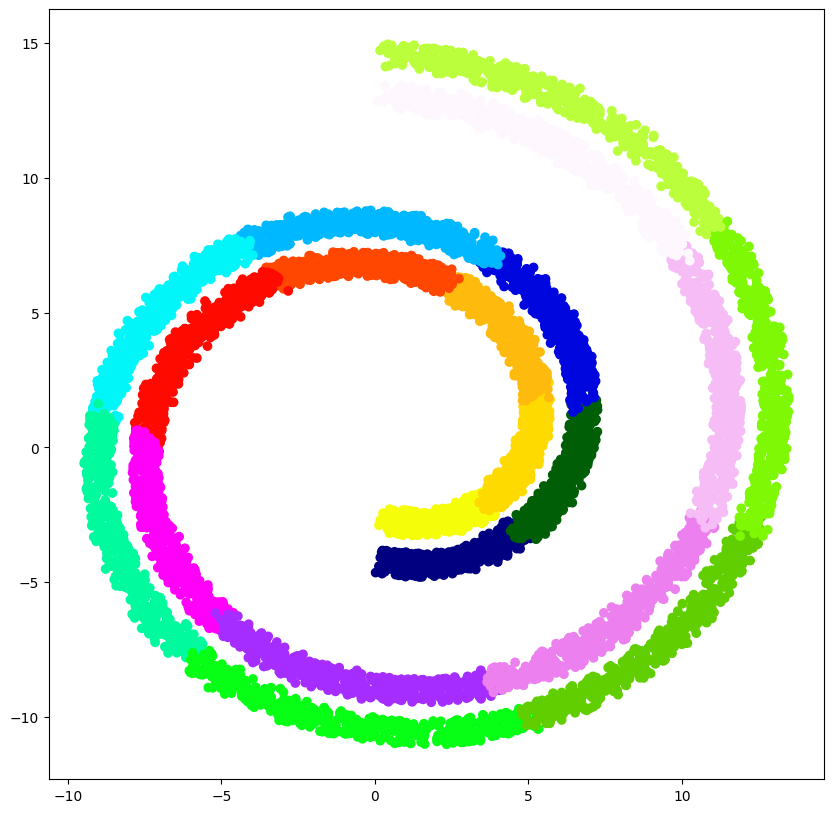

In [3]:

n_samples = 5000

t = np.sort(1.5 * np.pi * (1 + 2*np.random.uniform(size=n_samples)))
t2 = np.sort(1.5 * np.pi * (2/3 + 2*np.random.uniform(size=n_samples)))

x = t * np.cos(t)
y = t * np.sin(t)

x2 = t2 * np.cos(t2+np.pi/2)
y2 = t2 * np.sin(t2+np.pi/2)

X = np.vstack((x, y)).T
noise = 0.9 * np.random.random(size=(n_samples, 2))
X += noise
t = np.squeeze(t)

X2 = np.vstack((x2, y2)).T
noise2 = 0.9 * np.random.random(size=(n_samples, 2))
X2 += noise2
t2 = np.squeeze(t2)

k = 10
X_ = np.array_split(X, k)
X2_ = np.array_split(X2, k)

data = [np.concatenate((X_[i], X2_[i])) for i in range(k)]
labels = [np.concatenate((np.zeros(len(X_[i])), np.ones(len(X2_[i])))).astype(int) for i in range(k)]

cmap = plt.get_cmap("spring")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
colors = np.concatenate([labels[i]/2+i/(2*k) for i in range(k)])
data_concat = np.concatenate(data)
ax.scatter(data_concat[:,0], data_concat[:,1], c=colors, cmap="gist_ncar")

plt.show()

dataset = np.concatenate((X,X2))
xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
steps = 100
x_span = np.linspace(xmin, xmax, steps)
y_span = np.linspace(ymin, ymax, steps)
xx, yy = np.meshgrid(x_span, y_span)
grid = torch.autograd.Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device))

In [4]:
hidden = [128, 128]
epochs = 5

model = ModSequential(
        ModLinear(2, hidden[0], masked=True, prebatchnorm=False, learnable_mask=True),
        ModLinear(hidden[0], hidden[1], masked=True, prebatchnorm=False, learnable_mask=True),
        ModLinear(hidden[1], 2, masked=True, prebatchnorm=False, nonlinearity=""),
        track_activations=10,
        track_auxiliary_gradients=True
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

fig, ax = plt.subplots()
handles = []
camera = Camera(fig)
model.eval()
labels_predicted = model(grid)
labels_predicted = [1 if labels_predicted[i,0]<labels_predicted[i,1] else 0 for i in range(labels_predicted.shape[0])]
z = np.array(labels_predicted).reshape(xx.shape)        
ax.contourf(xx, yy, z, cmap="coolwarm")
handles.append(ax.scatter(X[:, 0], X[:, 1], c="blue"))
handles.append(ax.scatter(X2[:, 0], X2[:, 1], c="red"))
camera.snap()

print("This model has {} effective parameters.".format(model.parameter_count(masked = True)))

cmap = plt.get_cmap('rainbow')
datasets = [split_dataset(torch.Tensor(data[i]), torch.Tensor(labels[i]).long(), val_size = 0.1, test_size = 0.1, batch_size = 16) for i in range(k)]
timestamps = [[0] for i in range(k+1)]
accs = [[] for i in range(k+1)]
svd_scores = [[torch.zeros(0,hidden[0]) for i in range(k+1)] for _ in range(2)]
vars = [[torch.zeros(0,hidden[0]) for i in range(k+1)] for _ in range(2)]
orthog_gaps = [[[] for i in range(k+1)] for _ in range(2)]
effective_ranks = [[[] for i in range(k+1)] for _ in range(2)]
maxes = [[torch.zeros(0,hidden[0]) for i in range(k+1)] for _ in range(2)]

for i, vl in enumerate(datasets):
    loss, acc = test(model, datasets[i][1], criterion, device=device, verbose=False)
    accs[i] = [acc]
    for l, layer in enumerate(["0", "1"]):
        svd_scores[l][i] = svd_score(model.activations[layer], difference=True).unsqueeze(0)
        vars[l][i] = activation_variance(model.activations[layer]).unsqueeze(0)
        maxes[l][i] = torch.max(model.activations[layer], dim=0, keepdim=True).values
        orthog_gaps[l][i] = [orthogonality_gap(model.activations[layer]).item()]
        effective_ranks[l][i] = [effective_rank(model.activations[layer], partial=True).item()]
    timestamps[i] = [0]

for d in range(k):
    for e in range(epochs):
        train(model, datasets[d][0], optimizer, criterion, epochs=1, device=device, verbose=False)
        for l, layer in enumerate(["0", "1"]):
            svd_scores[l][-1] = torch.cat((svd_scores[l][-1], svd_score(model.activations[layer], difference=True).unsqueeze(0).detach()), dim=0)
            vars[l][-1] = torch.cat((vars[l][-1], activation_variance(model.activations[layer]).unsqueeze(0)), dim=0)
            maxes[l][-1] = torch.cat((maxes[l][-1], torch.max(model.activations[layer], dim=0, keepdim=True).values), dim=0)
            orthog_gaps[l][-1].append(orthogonality_gap(model.activations[layer]).item())
            effective_ranks[l][-1].append(effective_rank(model.activations[layer], partial=True).item())
        timestamps[-1].append(epochs*(d)+e+1)
        for i, vl in enumerate(datasets):
            loss, acc = test(model, datasets[i][1], criterion, device=device, verbose=False)
            accs[i].append(acc)
            for l, layer in enumerate(["0", "1"]):
                svd_scores[l][i] = torch.cat((svd_scores[l][i], svd_score(model.activations[layer], difference=True).unsqueeze(0)), dim=0)
                vars[l][i] = torch.cat((vars[l][i], activation_variance(model.activations[layer]).unsqueeze(0)), dim=0)
                maxes[l][i] = torch.cat((maxes[l][i], torch.max(model.activations[layer], dim=0, keepdim=True).values), dim=0)
                orthog_gaps[l][i].append(orthogonality_gap(model.activations[layer]).item())
                effective_ranks[l][i].append(effective_rank(model.activations[layer], partial=True).item())
            timestamps[i].append(epochs*(d)+e+1)
        model.eval()
        labels_predicted = model(grid)
        labels_predicted = [1 if labels_predicted[i,0]<labels_predicted[i,1] else 0 for i in range(labels_predicted.shape[0])]
        z = np.array(labels_predicted).reshape(xx.shape)   
        ax.contourf(xx, yy, z, cmap="coolwarm")
        ax.scatter(X[:, 0], X[:, 1], c="blue", alpha=0.1, s=1)
        ax.scatter(X2[:, 0], X2[:, 1], c="red", alpha=0.1, s=1)
        ax.scatter(X_[d][:, 0], X_[d][:, 1], c="blue")
        ax.scatter(X2_[d][:, 0], X2_[d][:, 1], c="red")
        camera.snap()

#track gradient norms
#plot per neuron

This model has 17154 effective parameters.


In [ ]:
anim = camera.animate()
HTML(anim.to_html5_video())

ValueError: x and y must have same first dimension, but have shapes (1,) and torch.Size([0, 128])

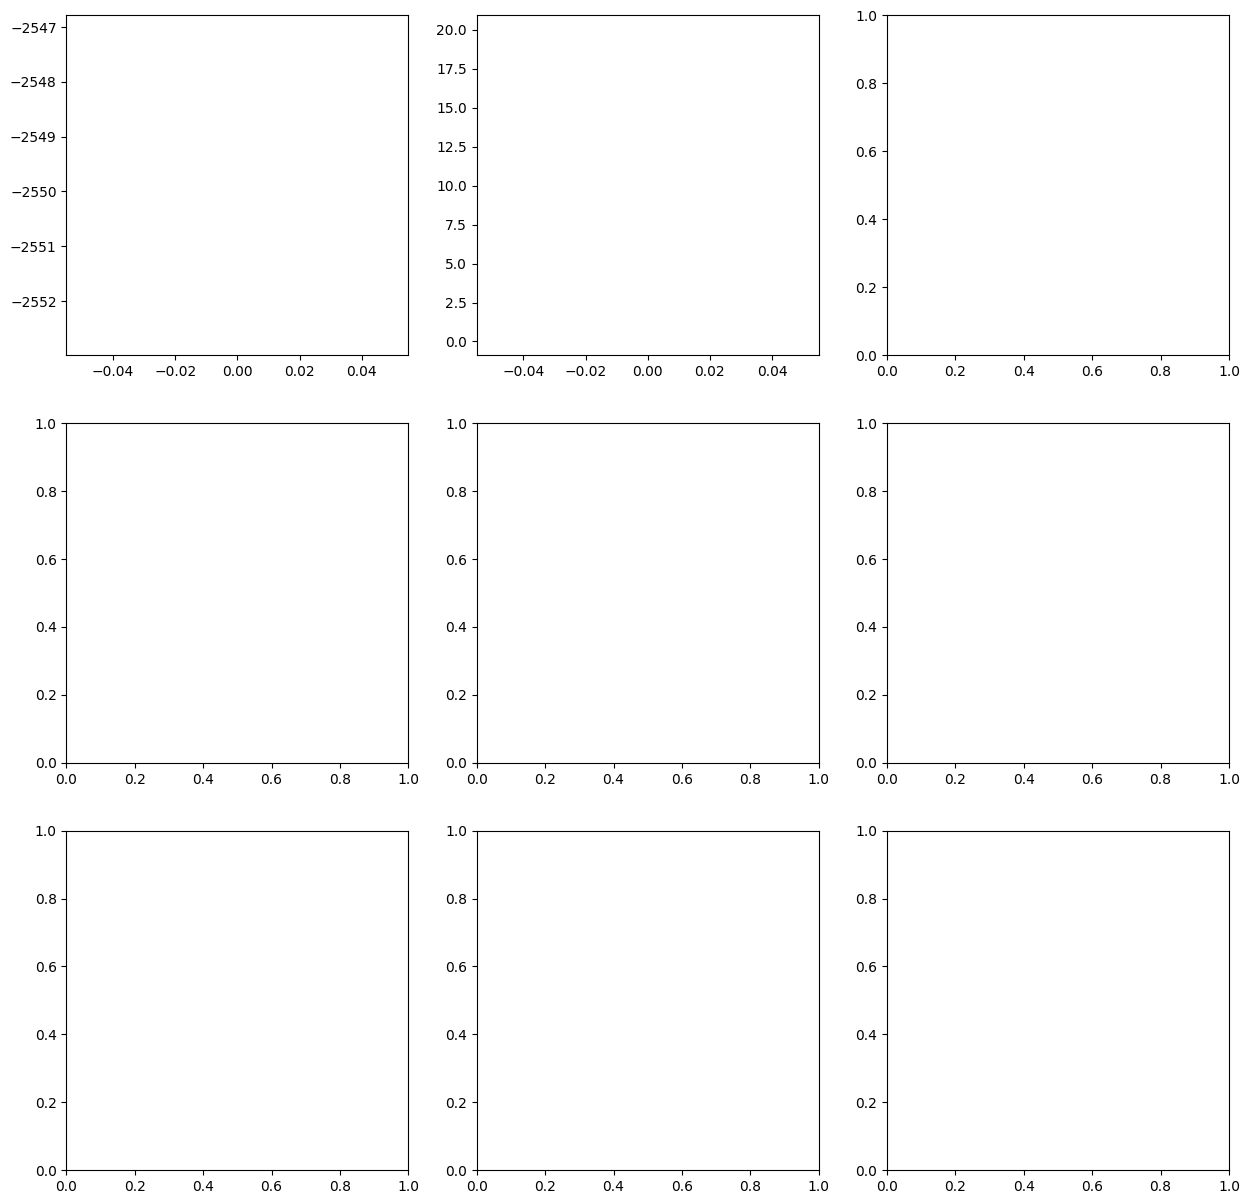

In [ ]:
use_maxes = True
if use_maxes:
    stat = maxes
else:
    stat = vars

colors = [cmap(i) for i in np.linspace(1, 0, k)]
fig, axs = plt.subplots(3,3, figsize=(15,15))
for layer in range(2):
    for i, scores in enumerate(svd_scores[layer]):
        axs[layer,1].plot(timestamps[i][-len(stat[layer][i]):], stat[layer][i].detach(), color=colors[i] if i < k else "black", alpha=0.1)
        for neuron in range(scores.shape[1]):
            axs[layer,0].plot(timestamps[i][-len(scores[:,neuron]):], scores[:,neuron].detach(), color=colors[i] if i < k else "black", label=None if neuron > 0 else "Subtask {}".format(i) if i < k else "Train")
    axs[layer,0].set_xlabel("Epochs")
    axs[layer,0].set_ylabel("SVD Scores")

    for i, gaps in enumerate(orthog_gaps[0]):
        axs[layer,2].plot(timestamps[i][-len(orthog_gaps[layer][i]):], orthog_gaps[layer][i], color=colors[i] if i < k else "black", label="Subtask {}".format(i)  if i < k else "Train")
        axs[2, layer+1].plot(timestamps[i][-len(effective_rank[layer][i]):], effective_rank[layer][i], color=colors[i] if i < k else "black", label="Subtask {}".format(i)  if i < k else "Train")
        #axs[1,0].fill_between(timestamps[i][-len(stat[i]):], torch.mean(stat[i], dim=1).detach()-torch.std(stat[i], dim=1).detach(), torch.mean(stat[i], dim=1).detach()+torch.std(maxes[i], dim=1).detach(), color=colors[i] if i < k else "black", alpha=0.2)
        axs[layer,1].plot(timestamps[i][-len(stat[0][i]):], torch.mean(stat[0][i], dim=1).detach(), color=colors[i] if i < k else "black", label="Subtask {}".format(i)  if i < k else "Train")
        if i < len(accs)-1 and layer == 0:
            try:
                axs[2,0].plot(timestamps[i][-len(accs[i]):], accs[i], color=colors[i] if i < k else "black", label="Subtask {}".format(i))
            except:
                axs[2,0].plot(timestamps[i][-len(accs[i]):]+[timestamps[i][-1]+1], accs[i], color=colors[i] if i < k else "black", label="Subtask {}".format(i))
    axs[layer,1].set_xlabel("Epochs")
    axs[layer,2].set_ylabel("Orthogonality Gap")
    axs[layer,2].set_xlabel("Epochs")
    if use_maxes:
        axs[layer,1].set_ylabel("Max Activation")
    else:
        axs[layer,1].set_ylabel("Activation Variance")
    #make y axis log scale
    #axs[1,0].set_yscale('log')
axs[2,0].set_xlabel("Epochs")
axs[2,0].set_ylabel("Validation Accuracy")
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()